<a href="https://colab.research.google.com/github/kcms2ll/AI-Study/blob/main/ETest/src/convolutional_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/rabbit_challenge/DNN_code')
sys.path.append('/content/drive/MyDrive/rabbit_challenge/DNN_code/lesson_2')

import numpy as np
import matplotlib.pyplot as plt
from common import functions

import numpy as np
from common import layers
from collections import OrderedDict
from common import functions
from data.mnist import load_mnist
import matplotlib.pyplot as plt
from multi_layer_net import MultiLayerNet

# CNN

## simple convolution network class

In [3]:
class SimpleConvNet:
    # conv - relu - pool - affine - relu - affine - softmax
    def __init__(self, input_dim=(1, 28, 28), conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']        
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2 * filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = layers.Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W3'], self.params['b3'])

        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for key in self.layers.keys():
            x = self.layers[key].forward(x)
        return x
        
    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td) 
        
        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W3'], grad['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grad

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.5264
                : 10. 正答率(テスト) = 0.491
Generation: 20. 正答率(トレーニング) = 0.6164
                : 20. 正答率(テスト) = 0.596
Generation: 30. 正答率(トレーニング) = 0.7622
                : 30. 正答率(テスト) = 0.736
Generation: 40. 正答率(トレーニング) = 0.7884
                : 40. 正答率(テスト) = 0.749
Generation: 50. 正答率(トレーニング) = 0.838
                : 50. 正答率(テスト) = 0.794
Generation: 60. 正答率(トレーニング) = 0.8514
                : 60. 正答率(テスト) = 0.817
Generation: 70. 正答率(トレーニング) = 0.8728
                : 70. 正答率(テスト) = 0.854
Generation: 80. 正答率(トレーニング) = 0.8866
                : 80. 正答率(テスト) = 0.858
Generation: 90. 正答率(トレーニング) = 0.884
                : 90. 正答率(テスト) = 0.853
Generation: 100. 正答率(トレーニング) = 0.8906
                : 100. 正答率(テスト) = 0.86
Generation: 110. 正答率(トレーニング) = 0.8924
                : 110. 正答率(テスト) = 0.87
Generation: 120. 正答率(トレーニング) = 0.8848
                : 120. 正答率(テスト) = 0.855
Generation: 130. 正答率(トレーニング) = 0.9022
                : 130. 正答率(テスト) = 0.87

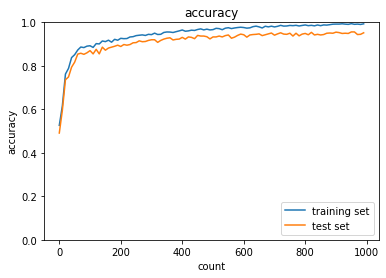

In [4]:
from common import optimizer
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

print("データ読み込み完了")

# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:5000], d_train[:5000]
x_test, d_test = x_test[:1000], d_test[:1000]


network = SimpleConvNet(input_dim=(1,28,28), conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer = optimizer.Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10



for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## double_comvolution_network

In [5]:
class DoubleConvNet:
    # conv - relu - conv - relu - pool - affine - relu - affine - softmax
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1={'filter_num':10, 'filter_size':7, 'pad':1, 'stride':1},
                 conv_param_2={'filter_num':20, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10, weight_init_std=0.01):
        conv_output_size_1 = (input_dim[1] - conv_param_1['filter_size'] + 2 * conv_param_1['pad']) / conv_param_1['stride'] + 1
        conv_output_size_2 = (conv_output_size_1 - conv_param_2['filter_size'] + 2 * conv_param_2['pad']) / conv_param_2['stride'] + 1        
        pool_output_size = int(conv_param_2['filter_num'] * (conv_output_size_2 / 2) * (conv_output_size_2 / 2))        
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(conv_param_1['filter_num'], input_dim[0], conv_param_1['filter_size'], conv_param_1['filter_size'])
        self.params['b1'] = np.zeros(conv_param_1['filter_num'])
        self.params['W2'] = weight_init_std * np.random.randn(conv_param_2['filter_num'], conv_param_1['filter_num'], conv_param_2['filter_size'], conv_param_2['filter_size'])
        self.params['b2'] = np.zeros(conv_param_2['filter_num'])
        self.params['W3'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b4'] = np.zeros(output_size)
        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = layers.Convolution(self.params['W1'], self.params['b1'], conv_param_1['stride'], conv_param_1['pad'])
        self.layers['Relu1'] = layers.Relu()
        self.layers['Conv2'] = layers.Convolution(self.params['W2'], self.params['b2'], conv_param_2['stride'], conv_param_2['pad'])
        self.layers['Relu2'] = layers.Relu()
        self.layers['Pool1'] = layers.Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = layers.Affine(self.params['W3'], self.params['b3'])
        self.layers['Relu3'] = layers.Relu()
        self.layers['Affine2'] = layers.Affine(self.params['W4'], self.params['b4'])
        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x):
        for key in self.layers.keys():
            x = self.layers[key].forward(x)
        return x
        
    def loss(self, x, d):
        y = self.predict(x)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td) 
        
        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)
        
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grad = {}
        grad['W1'], grad['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grad['W2'], grad['b2'] = self.layers['Conv2'].dW, self.layers['Conv2'].db        
        grad['W3'], grad['b3'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grad['W4'], grad['b4'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grad

データ読み込み完了
Generation: 10. 正答率(トレーニング) = 0.104
                : 10. 正答率(テスト) = 0.08
Generation: 20. 正答率(トレーニング) = 0.356
                : 20. 正答率(テスト) = 0.29
Generation: 30. 正答率(トレーニング) = 0.716
                : 30. 正答率(テスト) = 0.63
Generation: 40. 正答率(トレーニング) = 0.784
                : 40. 正答率(テスト) = 0.66
Generation: 50. 正答率(トレーニング) = 0.802
                : 50. 正答率(テスト) = 0.69
Generation: 60. 正答率(トレーニング) = 0.788
                : 60. 正答率(テスト) = 0.73
Generation: 70. 正答率(トレーニング) = 0.868
                : 70. 正答率(テスト) = 0.78
Generation: 80. 正答率(トレーニング) = 0.864
                : 80. 正答率(テスト) = 0.8
Generation: 90. 正答率(トレーニング) = 0.866
                : 90. 正答率(テスト) = 0.83
Generation: 100. 正答率(トレーニング) = 0.902
                : 100. 正答率(テスト) = 0.87


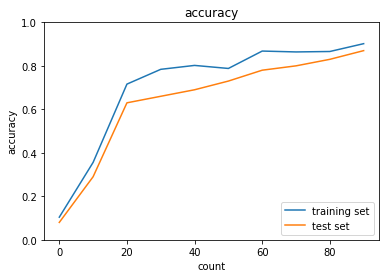

In [6]:
from common import optimizer
# データの読み込み
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

print("データ読み込み完了")
# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:500], d_train[:500]
x_test, d_test = x_test[:100], d_test[:100]


network = DoubleConvNet(input_dim=(1,28,28), 
                          conv_param_1={'filter_num':10, 'filter_size':7, 'pad':1, 'stride':1},
                          conv_param_2={'filter_num':20, 'filter_size':3, 'pad':1, 'stride':1},
                          hidden_size=100, output_size=10, weight_init_std=0.01)

optimizer = optimizer.Adam()

# 時間がかかるため100に設定
iters_num = 100
# iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10



for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)
    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()

## deep convolution network

In [7]:
class DeepConvNet:
    '''
    認識率99%以上の高精度なConvNet

    conv - relu - conv- relu - pool -
    conv - relu - conv- relu - pool -
    conv - relu - conv- relu - pool -
    affine - relu - dropout - affine - dropout - softmax
    '''
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 重みの初期化===========
        # 各層のニューロンひとつあたりが、前層のニューロンといくつのつながりがあるか
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # Heの初期値
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(pre_node_nums[6], hidden_size)
        print(self.params['W7'].shape)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(pre_node_nums[7], output_size)
        self.params['b8'] = np.zeros(output_size)

        # レイヤの生成===========
        self.layers = []
        self.layers.append(layers.Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(layers.Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(layers.Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(layers.Affine(self.params['W7'], self.params['b7']))
        self.layers.append(layers.Relu())
        self.layers.append(layers.Dropout(0.5))
        self.layers.append(layers.Affine(self.params['W8'], self.params['b8']))
        self.layers.append(layers.Dropout(0.5))
        
        self.last_layer = layers.SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, layers.Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, d):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, d)

    def accuracy(self, x, d, batch_size=100):
        if d.ndim != 1 : d = np.argmax(d, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            td = d[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == td)

        return acc / x.shape[0]

    def gradient(self, x, d):
        # forward
        self.loss(x, d)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

データ読み込み完了
(1024, 50)
Generation: 10. 正答率(トレーニング) = 0.456
                : 10. 正答率(テスト) = 0.41
Generation: 20. 正答率(トレーニング) = 0.506
                : 20. 正答率(テスト) = 0.49
Generation: 30. 正答率(トレーニング) = 0.56
                : 30. 正答率(テスト) = 0.57
Generation: 40. 正答率(トレーニング) = 0.694
                : 40. 正答率(テスト) = 0.67
Generation: 50. 正答率(トレーニング) = 0.8
                : 50. 正答率(テスト) = 0.68
Generation: 60. 正答率(トレーニング) = 0.878
                : 60. 正答率(テスト) = 0.79
Generation: 70. 正答率(トレーニング) = 0.894
                : 70. 正答率(テスト) = 0.82
Generation: 80. 正答率(トレーニング) = 0.906
                : 80. 正答率(テスト) = 0.79
Generation: 90. 正答率(トレーニング) = 0.924
                : 90. 正答率(テスト) = 0.84
Generation: 100. 正答率(トレーニング) = 0.932
                : 100. 正答率(テスト) = 0.86
Generation: 110. 正答率(トレーニング) = 0.944
                : 110. 正答率(テスト) = 0.86
Generation: 120. 正答率(トレーニング) = 0.952
                : 120. 正答率(テスト) = 0.88
Generation: 130. 正答率(トレーニング) = 0.956
                : 130. 正答率(テスト) = 0.86
Generation: 

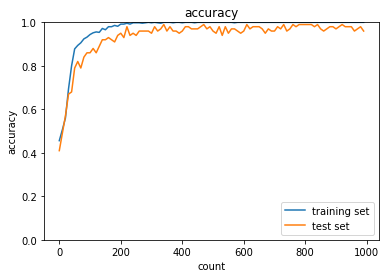

In [8]:
from common import optimizer
(x_train, d_train), (x_test, d_test) = load_mnist(flatten=False)

# 処理に時間のかかる場合はデータを削減 
x_train, d_train = x_train[:500], d_train[:500]
x_test, d_test = x_test[:100], d_test[:100]

print("データ読み込み完了")

network = DeepConvNet()  
optimizer = optimizer.Adam()

iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
accuracies_train = []
accuracies_test = []

plot_interval=10


for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    d_batch = d_train[batch_mask]
    
    grad = network.gradient(x_batch, d_batch)
    optimizer.update(network.params, grad)

    loss = network.loss(x_batch, d_batch)
    train_loss_list.append(loss)

    if (i+1) % plot_interval == 0:
        accr_train = network.accuracy(x_train, d_train)
        accr_test = network.accuracy(x_test, d_test)
        accuracies_train.append(accr_train)
        accuracies_test.append(accr_test)
        
        print('Generation: ' + str(i+1) + '. 正答率(トレーニング) = ' + str(accr_train))
        print('                : ' + str(i+1) + '. 正答率(テスト) = ' + str(accr_test))               

lists = range(0, iters_num, plot_interval)
plt.plot(lists, accuracies_train, label="training set")
plt.plot(lists, accuracies_test,  label="test set")
plt.legend(loc="lower right")
plt.title("accuracy")
plt.xlabel("count")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
# グラフの表示
plt.show()